# Importing Libraries


In [1]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from facenet_pytorch import MTCNN
import seaborn as sns
import json
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import glob
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
from datetime import datetime
import warnings

Matplotlib is building the font cache; this may take a moment.
c:\Users\Haya\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading & Combining Dataset

In [2]:
# =============================================================================
# SECTION 1: DATASET PATHS
# =============================================================================

print("="*60)
print("MTCNN PREPROCESSING + ACCURACY")
print("="*60)

# Base path 
base_path = r'D:\DEPE Project\real_vs_fake\real-vs-fake'

train_real = os.path.join(base_path, 'train', 'real')
train_fake = os.path.join(base_path, 'train', 'fake')
valid_real = os.path.join(base_path, 'valid', 'real')
valid_fake = os.path.join(base_path, 'valid', 'fake')
test_real = os.path.join(base_path, 'test', 'real')
test_fake = os.path.join(base_path, 'test', 'fake')


print(f"\nDataset Path: {base_path}")



MTCNN PREPROCESSING + ACCURACY

Dataset Path: D:\DEPE Project\real_vs_fake\real-vs-fake


In [4]:
# =============================================================================
# SECTION 2: DATASET QUALITY CHECK
# =============================================================================

print("\n" + "="*60)
print("ORIGINAL DATASET STATISTICS")
print("="*60)

def count_images(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    return 0
# Count original images
original_stats = {
    'train_real': count_images(train_real),
    'train_fake': count_images(train_fake),
    'valid_real': count_images(valid_real),
    'valid_fake': count_images(valid_fake),
    'test_real': count_images(test_real),
    'test_fake': count_images(test_fake)
}

print(f"\nTRAIN:")
print(f"Real: {original_stats['train_real']:,} images")
print(f"Fake: {original_stats['train_fake']:,} images")
print(f"Total: {original_stats['train_real'] + original_stats['train_fake']:,}")

print(f"\nVALIDATION:")
print(f"Real: {original_stats['valid_real']:,} images")
print(f"Fake: {original_stats['valid_fake']:,} images")
print(f"Total: {original_stats['valid_real'] + original_stats['valid_fake']:,}")

print(f"\nTEST:")
print(f"Real: {original_stats['test_real']:,} images")
print(f"Fake: {original_stats['test_fake']:,} images")
print(f"Total: {original_stats['test_real'] + original_stats['test_fake']:,}")

original_total = sum(original_stats.values())
print(f"\nGRAND TOTAL: {original_total:,} images")



ORIGINAL DATASET STATISTICS

TRAIN:
Real: 50,000 images
Fake: 50,000 images
Total: 100,000

VALIDATION:
Real: 10,000 images
Fake: 10,000 images
Total: 20,000

TEST:
Real: 10,000 images
Fake: 10,000 images
Total: 20,000

GRAND TOTAL: 140,000 images


In [5]:
# =============================================================================
# SECTION 3: QUALITY CHECKS
# =============================================================================

print("\n" + "="*60)
print("IMAGE QUALITY CHECKS")
print("="*60)

# Check sample images
print("\nChecking sample images")
sample_files = [f for f in os.listdir(train_real) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:3]
for fname in sample_files:
    img_path = os.path.join(train_real, fname)
    try:
        with Image.open(img_path) as img:
            print(f" {fname}: {img.size} | {img.mode}")
    except Exception as e:
        print(f"     {fname}: Error - {e}")

# Resolution check
def get_image_resolutions(path, limit=500):
    resolutions = []
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:limit]
    for fname in files:
        img_path = os.path.join(path, fname)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                resolutions.append((w, h))
        except:
            continue
    return resolutions

real_res = get_image_resolutions(train_real)
fake_res = get_image_resolutions(train_fake)

print(f"\nMost common resolutions:")
print(f" Real: {Counter(real_res).most_common(3)}")
print(f" Fake: {Counter(fake_res).most_common(3)}")

# Blurriness check
def detect_blurriness(path, limit=300):
    blur_scores = []
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:limit]
    for fname in files:
        img_path = os.path.join(path, fname)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                score = cv2.Laplacian(img, cv2.CV_64F).var()
                blur_scores.append(score)
        except:
            continue
    return blur_scores

real_blur = detect_blurriness(train_real)
fake_blur = detect_blurriness(train_fake)

print(f"\nBlur Scores (higher = sharper):")
print(f" Real Mean: {np.mean(real_blur):.2f}")
print(f" Fake Mean: {np.mean(fake_blur):.2f}")


IMAGE QUALITY CHECKS

Checking sample images
 00000.jpg: (256, 256) | RGB
 00002.jpg: (256, 256) | RGB
 00003.jpg: (256, 256) | RGB

Most common resolutions:
 Real: [((256, 256), 500)]
 Fake: [((256, 256), 500)]

Blur Scores (higher = sharper):
 Real Mean: 1157.34
 Fake Mean: 1079.82



Showing sample images:


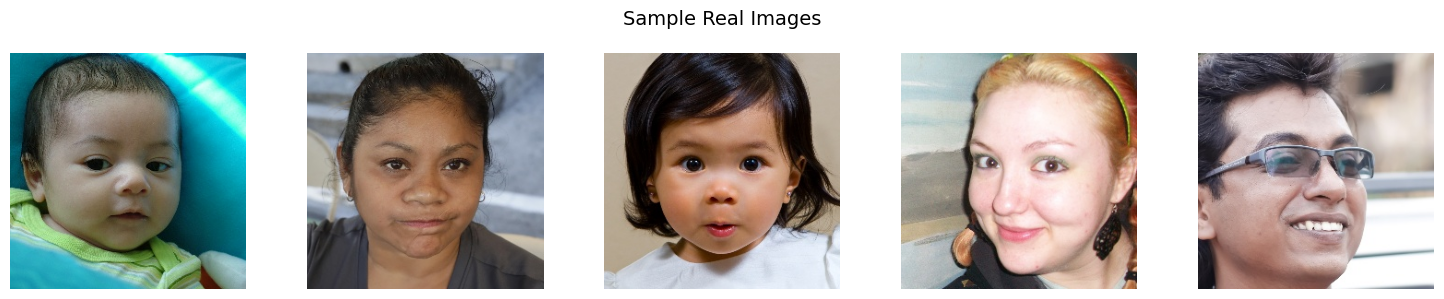

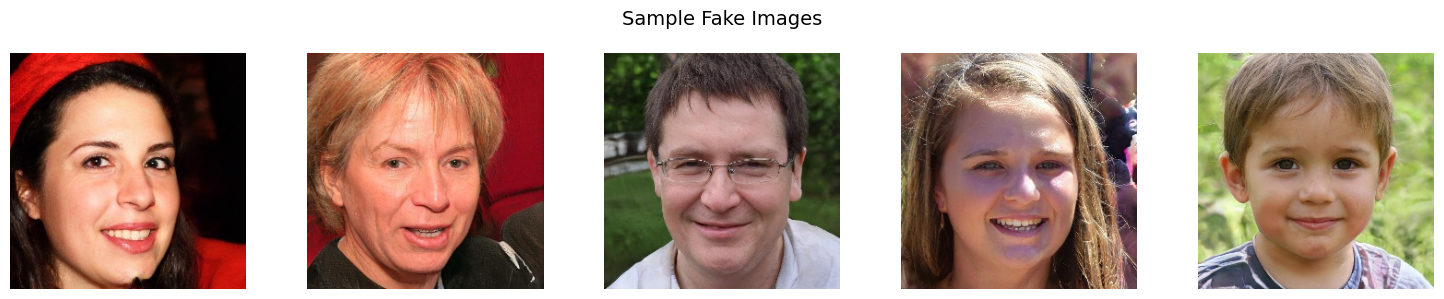

In [6]:
# =============================================================================
# SECTION 4: PREVIEW SAMPLE IMAGES
# =============================================================================

def show_samples(path, title, n=5):
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:n]
    if len(files) == 0:
        return
    
    plt.figure(figsize=(15, 3))
    for i, fname in enumerate(files):
        img = cv2.imread(os.path.join(path, fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nShowing sample images:")
show_samples(train_real, 'Sample Real Images')
show_samples(train_fake, 'Sample Fake Images')


In [7]:
# =============================================================================
# SECTION 5: MTCNN PREPROCESSING WITH LANDMARKS
# =============================================================================
print("\n" + "="*60)
print(" MTCNN PREPROCESSING WITH LANDMARKS")
print("="*60)

# Output paths
preprocessed_base = r'D:\DEPE Project\preprocessed'
landmarks_base = r'D:\DEPE Project\landmarks'

preprocessed_paths = {
    'train_real': os.path.join(preprocessed_base, 'train', 'real'),
    'train_fake': os.path.join(preprocessed_base, 'train', 'fake'),
    'val_real': os.path.join(preprocessed_base, 'val', 'real'),
    'val_fake': os.path.join(preprocessed_base, 'val', 'fake'),
    'test_real': os.path.join(preprocessed_base, 'test', 'real'),
    'test_fake': os.path.join(preprocessed_base, 'test', 'fake')
}

# Create directories
for path in preprocessed_paths.values():
    os.makedirs(path, exist_ok=True)

os.makedirs(landmarks_base, exist_ok=True)

# Check if already preprocessed
already_done = all(len(os.listdir(path)) > 0 for path in preprocessed_paths.values())

if already_done:
    print("\n Preprocessed data already exists!")
    for name, path in preprocessed_paths.items():
        count = len(os.listdir(path))
        print(f"   {name}: {count:,} images")
    print("\n Skipping preprocessing")
    
else:
    print("\n Starting MTCNN preprocessing with landmarks")
    
    # Initialize MTCNN
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f" Device: {device}")
    
    mtcnn = MTCNN(
        image_size=224,
        margin=20,
        keep_all=False,
        device=device,
        post_process=False
    )
    
    print(" MTCNN initialized")
    print(" Face Landmarks detection enabled")
    
    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        zoom_range=0.1
    )
    
    print(" Augmentation configured")
    
    def preprocess_and_augment(input_dir, output_dir, prefix):
        counter = 0
        skipped = 0
        landmarks_data = []
        
        files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for file in tqdm(files, desc=f'   {prefix}'):
            try:
                img_path = os.path.join(input_dir, file)
                
                # Check file exists
                if not os.path.isfile(img_path):
                    continue
                
                # Load image
                img_pil = Image.open(img_path).convert('RGB')
                
                # ================================================
                # Face Detection + Landmarks Extraction
                # ================================================
                boxes, probs, landmarks = mtcnn.detect(img_pil, landmarks=True)
                
                if boxes is None or len(boxes) == 0:
                    skipped += 1
                    continue
                
                # Get first (best) face
                box = boxes[0]
                prob = probs[0] if probs is not None else 0
                landmark = landmarks[0] if landmarks is not None else None
                
                # ================================================
                # Save Landmarks Information
                # ================================================
                if landmark is not None:
                    landmarks_data.append({
                        'file': f'{prefix}_{counter}.jpg',
                        'confidence': float(prob),
                        'landmarks': landmark.tolist(),
                        'points': {
                            'left_eye': landmark[0].tolist(),
                            'right_eye': landmark[1].tolist(),
                            'nose': landmark[2].tolist(),
                            'left_mouth': landmark[3].tolist(),
                            'right_mouth': landmark[4].tolist()
                        }
                    })
                
                # ================================================
                # Crop Face
                # ================================================
                x1, y1, x2, y2 = [int(b) for b in box]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(img_pil.width, x2), min(img_pil.height, y2)
                
                face_img_pil = img_pil.crop((x1, y1, x2, y2))
                
                # ================================================
                # Resize to 224x224
                # ================================================
                face_img_pil = face_img_pil.resize((224, 224), Image.BILINEAR)
                face_img = np.array(face_img_pil) / 255.0
                
                # ================================================
                # Save Original Preprocessed Image
                # ================================================
                save_path = os.path.join(output_dir, f'{prefix}_{counter}.jpg')
                Image.fromarray((face_img * 255).astype(np.uint8)).save(save_path, quality=95)
                
                # ================================================
                # Data Augmentation (2 variants)
                # ================================================
                img_exp = np.expand_dims(face_img, 0)
                aug_iter = datagen.flow(img_exp, batch_size=1)
                
                for i in range(2):
                    aug_img = next(aug_iter)[0]
                    aug_path = os.path.join(output_dir, f'{prefix}_{counter}_aug{i}.jpg')
                    Image.fromarray((aug_img * 255).astype(np.uint8)).save(aug_path, quality=95)
                
                counter += 1
                
            except Exception:
                skipped += 1
                continue
        
        # ====================================================
        # Save Landmarks to JSON File
        # ====================================================
        if landmarks_data:
            landmarks_file = os.path.join(landmarks_base, f'{prefix}_landmarks.json')
            with open(landmarks_file, 'w') as f:
                json.dump(landmarks_data, f, indent=2)
            print(f"\n Landmarks saved: {os.path.basename(landmarks_file)}")
        
        print(f"\n {prefix}:")
        print(f"Processed: {counter:,}")
        print(f"Skipped: {skipped:,}")
        print(f"Landmarks detected: {len(landmarks_data):,}")
        print(f"Total output: {counter*3:,} (with augmentation)")
        
        return counter, skipped
    
    # Process all datasets
    print("\n Processing datasets")
    
    stats = {}
    print("\n TRAIN SET:")
    p, s = preprocess_and_augment(train_real, preprocessed_paths['train_real'], 'train_real')
    stats['train_real'] = {'processed': p, 'skipped': s}
    p, s = preprocess_and_augment(train_fake, preprocessed_paths['train_fake'], 'train_fake')
    stats['train_fake'] = {'processed': p, 'skipped': s}
    print("\n VALIDATION SET:")
    p, s = preprocess_and_augment(valid_real, preprocessed_paths['val_real'], 'val_real')
    stats['val_real'] = {'processed': p, 'skipped': s}
    p, s = preprocess_and_augment(valid_fake, preprocessed_paths['val_fake'], 'val_fake')
    stats['val_fake'] = {'processed': p, 'skipped': s}
    print("\n TEST SET:")
    p, s = preprocess_and_augment(test_real, preprocessed_paths['test_real'], 'test_real')
    stats['test_real'] = {'processed': p, 'skipped': s}
    p, s = preprocess_and_augment(test_fake, preprocessed_paths['test_fake'], 'test_fake')
    stats['test_fake'] = {'processed': p, 'skipped': s}
    print("\n" + "="*60)
    print(" PREPROCESSING WITH LANDMARKS COMPLETE")
    print("="*60)



 MTCNN PREPROCESSING WITH LANDMARKS

 Starting MTCNN preprocessing with landmarks


c:\Users\Haya\AppData\Local\Programs\Python\Python310\lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

 Device: cuda
 MTCNN initialized
 Face Landmarks detection enabled
 Augmentation configured

 Processing datasets

 TRAIN SET:


   train_real: 100%|██████████| 50000/50000 [1:00:05<00:00, 13.87it/s]



 Landmarks saved: train_real_landmarks.json

 train_real:
Processed: 49,991
Skipped: 9
Landmarks detected: 49,991
Total output: 149,973 (with augmentation)


   train_fake: 100%|██████████| 50000/50000 [59:19<00:00, 14.05it/s] 



 Landmarks saved: train_fake_landmarks.json

 train_fake:
Processed: 49,998
Skipped: 2
Landmarks detected: 49,998
Total output: 149,994 (with augmentation)

 VALIDATION SET:


   val_real: 100%|██████████| 10000/10000 [11:59<00:00, 13.89it/s]



 Landmarks saved: val_real_landmarks.json

 val_real:
Processed: 9,998
Skipped: 2
Landmarks detected: 9,998
Total output: 29,994 (with augmentation)


   val_fake: 100%|██████████| 10000/10000 [11:55<00:00, 13.98it/s]



 Landmarks saved: val_fake_landmarks.json

 val_fake:
Processed: 10,000
Skipped: 0
Landmarks detected: 10,000
Total output: 30,000 (with augmentation)

 TEST SET:


   test_real: 100%|██████████| 10000/10000 [11:47<00:00, 14.14it/s]



 Landmarks saved: test_real_landmarks.json

 test_real:
Processed: 9,998
Skipped: 2
Landmarks detected: 9,998
Total output: 29,994 (with augmentation)


   test_fake: 100%|██████████| 10000/10000 [11:50<00:00, 14.08it/s]



 Landmarks saved: test_fake_landmarks.json

 test_fake:
Processed: 10,000
Skipped: 0
Landmarks detected: 10,000
Total output: 30,000 (with augmentation)

 PREPROCESSING WITH LANDMARKS COMPLETE



 Previewing preprocessed images: 


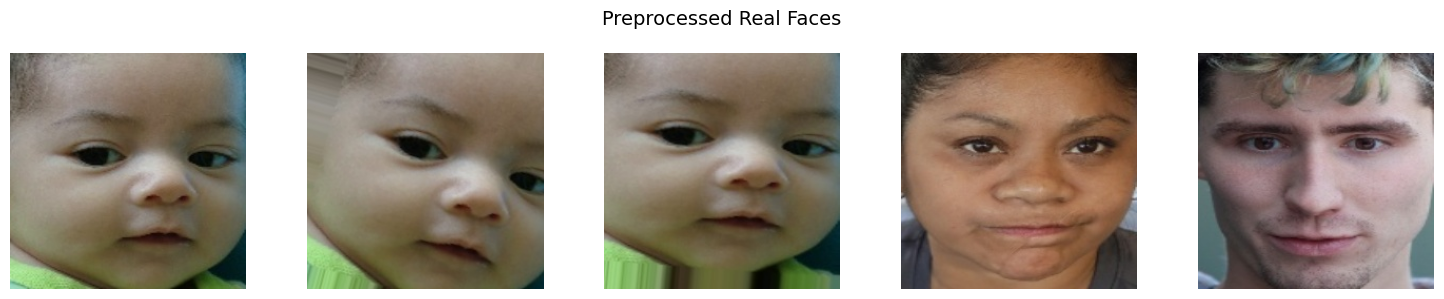

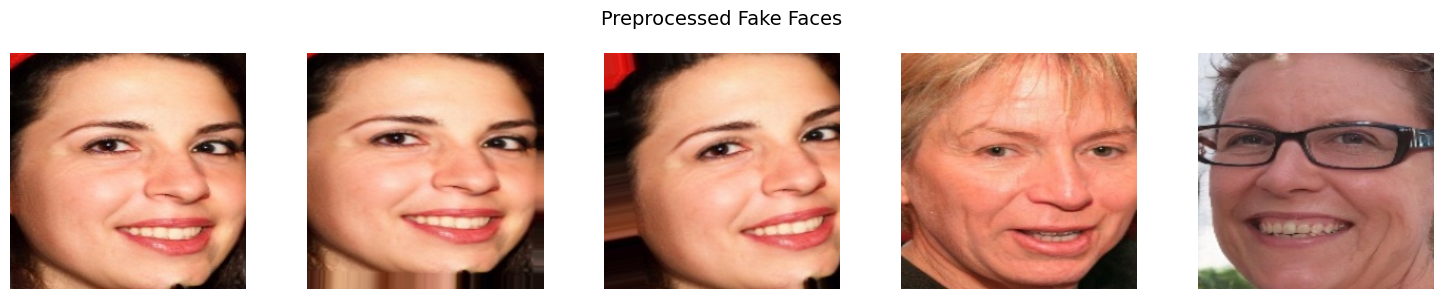

In [8]:
# =============================================================================
# SECTION 6: PREVIEW PREPROCESSED IMAGES
# =============================================================================

print("\n Previewing preprocessed images: ")
show_samples(preprocessed_paths['train_real'], 'Preprocessed Real Faces')
show_samples(preprocessed_paths['train_fake'], 'Preprocessed Fake Faces')


In [9]:
# =============================================================================
# SECTION 7: ACCURACY & STATISTICS
# =============================================================================

print("\n" + "="*60)
print(" PREPROCESSING ACCURACY & STATISTICS")
print("="*60)

# Count preprocessed (divide by 3 for actual count without augmentation)
preprocessed_stats = {}
for name, path in preprocessed_paths.items():
    total = len(os.listdir(path))
    actual = total // 3
    preprocessed_stats[name] = {'total': total, 'actual': actual}

print(f"\n MTCNN Face Detection Success Rate:")

for key in ['train_real', 'train_fake', 'val_real', 'val_fake', 'test_real', 'test_fake']:
    original = original_stats.get(key, 0)
    processed = preprocessed_stats[key]['actual']
    success_rate = (processed / original * 100) if original > 0 else 0
    print(f"   {key}: {success_rate:.2f}% ({processed:,}/{original:,})")

# Overall stats
train_total = preprocessed_stats['train_real']['total'] + preprocessed_stats['train_fake']['total']
val_total = preprocessed_stats['val_real']['total'] + preprocessed_stats['val_fake']['total']
test_total = preprocessed_stats['test_real']['total'] + preprocessed_stats['test_fake']['total']

print(f"\n Preprocessed Dataset (with augmentation):")
print(f"TRAIN: {train_total:,} images")
print(f"VAL:   {val_total:,} images")
print(f"TEST:  {test_total:,} images")
print(f"TOTAL: {train_total + val_total + test_total:,} images")

# Landmarks statistics
print(f"\n Face Landmarks Statistics:")
if os.path.exists(landmarks_base):
    landmarks_files = [f for f in os.listdir(landmarks_base) if f.endswith('.json')]
    total_landmarks = 0
    
    for lm_file in sorted(landmarks_files):
        lm_path = os.path.join(landmarks_base, lm_file)
        try:
            with open(lm_path, 'r') as f:
                data = json.load(f)
                total_landmarks += len(data)
                print(f"   {lm_file}: {len(data):,} faces with landmarks")
        except:
            continue
    
    print(f"Total landmarks extracted: {total_landmarks:,}")
else:
    print("No landmarks data found")

# Data balance
train_real_count = preprocessed_stats['train_real']['total']
train_fake_count = preprocessed_stats['train_fake']['total']
train_balance = (train_real_count / (train_real_count + train_fake_count) * 100) if (train_real_count + train_fake_count) > 0 else 0

val_real_count = preprocessed_stats['val_real']['total']
val_fake_count = preprocessed_stats['val_fake']['total']
val_balance = (val_real_count / (val_real_count + val_fake_count) * 100) if (val_real_count + val_fake_count) > 0 else 0

test_real_count = preprocessed_stats['test_real']['total']
test_fake_count = preprocessed_stats['test_fake']['total']
test_balance = (test_real_count / (test_real_count + test_fake_count) * 100) if (test_real_count + test_fake_count) > 0 else 0

print(f"\n Data Balance:")
print(f"Train: {train_balance:.1f}% Real / {100-train_balance:.1f}% Fake")
print(f"Val:   {val_balance:.1f}% Real / {100-val_balance:.1f}% Fake")
print(f"Test:  {test_balance:.1f}% Real / {100-test_balance:.1f}% Fake")

if 45 <= train_balance <= 55:
    print("\n Dataset is well-balanced")
else:
    print("\n Dataset may be imbalanced")

# =============================================================================
# MTCNN ACCURACY CALCULATION
# =============================================================================

print(f"\nMTCNN MODEL ACCURACY:")

# Calculate overall detection accuracy
total_original = sum(original_stats.values())
total_detected = sum(preprocessed_stats[key]['actual'] for key in preprocessed_stats.keys())
total_skipped = total_original - total_detected

overall_accuracy = (total_detected / total_original * 100) if total_original > 0 else 0

print(f"\n Overall Detection Accuracy: {overall_accuracy:.2f}%")
print(f"\n Output Directories:")
print(f"   Preprocessed images: {preprocessed_base}")
print(f"   Face landmarks JSON: {landmarks_base}")



 PREPROCESSING ACCURACY & STATISTICS

 MTCNN Face Detection Success Rate:
   train_real: 99.98% (49,991/50,000)
   train_fake: 100.00% (49,998/50,000)
   val_real: 0.00% (9,998/0)
   val_fake: 0.00% (10,000/0)
   test_real: 99.98% (9,998/10,000)
   test_fake: 100.00% (10,000/10,000)

 Preprocessed Dataset (with augmentation):
TRAIN: 299,967 images
VAL:   59,994 images
TEST:  59,994 images
TOTAL: 419,955 images

 Face Landmarks Statistics:
   test_fake_landmarks.json: 10,000 faces with landmarks
   test_real_landmarks.json: 9,998 faces with landmarks
   train_fake_landmarks.json: 49,998 faces with landmarks
   train_real_landmarks.json: 49,991 faces with landmarks
   val_fake_landmarks.json: 10,000 faces with landmarks
   val_real_landmarks.json: 9,998 faces with landmarks
Total landmarks extracted: 139,985

 Data Balance:
Train: 50.0% Real / 50.0% Fake
Val:   50.0% Real / 50.0% Fake
Test:  50.0% Real / 50.0% Fake

 Dataset is well-balanced

MTCNN MODEL ACCURACY:

 Overall Detection Ac

In [ ]:
print("\n" + "="*60)
print("MTCNN Real-Time Face Detection")
print("="*60)

device = 'cpu'
print(f"Using device: {device}")

print("Initializing MTCNN...")
mtcnn = MTCNN(
    keep_all=True,
    device=device,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],
    post_process=True
)
print("✓ MTCNN initialized!")

print("Opening camera...")
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

time.sleep(2)

if not cap.isOpened():
    print("✗ Cannot open camera")
    exit()

print("✓ Camera opened!")

ret, frame = cap.read()
if not ret:
    print("✗ Cannot read from camera")
    cap.release()
    exit()

print(f"✓ Frame size: {frame.shape}")

window_name = 'MTCNN Live Detection'
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 800, 600)

# جعل النافذة في المقدمة دائماً
cv2.setWindowProperty(window_name, cv2.WND_PROP_TOPMOST, 1)

print("\n" + "="*60)
print("CONTROLS:")
print("  Press 'q' or 'ESC' to quit")
print("  Press 'SPACE' to pause/resume")
print("  Close window to exit")
print("="*60 + "\n")

frame_count = 0
fps_time = time.time()
fps = 0
paused = False
running = True

try:
    while running:
        if not paused:
            ret, frame = cap.read()
            
            if not ret:
                print("✗ Failed to read frame")
                break
            
            frame_count += 1
            
            # حساب FPS
            if frame_count % 30 == 0:
                current_time = time.time()
                fps = 30 / (current_time - fps_time)
                fps_time = current_time
                print(f"Frame {frame_count} | FPS: {fps:.1f}")
            
            # معالجة كل إطارين
            if frame_count % 2 == 0:
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                try:
                    boxes, probs, landmarks = mtcnn.detect(rgb_frame, landmarks=True)
                    
                    faces_detected = 0
                    
                    if boxes is not None:
                        faces_detected = len(boxes)
                        
                        for box, prob, landmark in zip(boxes, probs, landmarks):
                            x1, y1, x2, y2 = [int(coord) for coord in box]
                            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                            
                            cv2.putText(frame, f'{prob*100:.1f}%', 
                                      (x1, y1 - 10),
                                      cv2.FONT_HERSHEY_SIMPLEX, 
                                      0.6, (0, 255, 0), 2)
                            
                            if landmark is not None:
                                for point in landmark:
                                    cv2.circle(frame, 
                                             (int(point[0]), int(point[1])), 
                                             4, (0, 0, 255), -1)
                    
                except Exception as e:
                    faces_detected = 0
            
            # عرض المعلومات
            cv2.putText(frame, f'FPS: {fps:.1f}', (10, 40),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.putText(frame, f'Faces: {faces_detected if "faces_detected" in locals() else 0}', 
                       (10, 90),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.putText(frame, "Press 'Q' or 'ESC' to quit", 
                       (10, frame.shape[0] - 20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        
        else:
            # في حالة التوقف المؤقت
            cv2.putText(frame, "PAUSED - Press SPACE to resume", 
                       (50, frame.shape[0]//2),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
        
        # عرض الصورة
        cv2.imshow(window_name, frame)
        
        # التحقق من الأزرار
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q') or key == ord('Q') or key == 27:  # q أو Q أو ESC
            print("\n✓ Exit key pressed - Quitting...")
            running = False
            break
        elif key == ord(' '):  # SPACE للتوقف المؤقت
            paused = not paused
            print(f"{'Paused' if paused else 'Resumed'}")
        
        # التحقق من إغلاق النافذة
        if cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
            print("\n✓ Window closed - Quitting...")
            running = False
            break

except KeyboardInterrupt:
    print("\n✓ Interrupted by user (Ctrl+C)")
except Exception as e:
    print(f"\n✗ Error: {e}")
finally:
    # التنظيف الكامل
    print("\nCleaning up...")
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)  # انتظر frame واحد للتأكد من الإغلاق
    
    print(f"\n✓ Total frames processed: {frame_count}")
    print("✓ Camera closed successfully")
    print("="*60)


MTCNN Real-Time Face Detection
Using device: cpu
Initializing MTCNN...
✓ MTCNN initialized!
Opening camera...
✓ Camera opened!
✓ Frame size: (480, 640, 3)

CONTROLS:
  Press 'q' or 'ESC' to quit
  Press 'SPACE' to pause/resume
  Close window to exit

Frame 30 | FPS: 20.6

✓ Window closed - Quitting...

Cleaning up...

✓ Total frames processed: 38
✓ Camera closed successfully


In [5]:
# ============================================================================
# IMPORTS
# ============================================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
import json

print("="*80)
print(" COMPLETE ANTI-SPOOFING PIPELINE - EfficientNet-B3")
print("="*80)

# تحقق من GPU
print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if tf.config.list_physical_devices('GPU'):
    print(f"GPU Device: {tf.config.list_physical_devices('GPU')[0]}")
print("="*80)
print(" COMPLETE ANTI-SPOOFING PIPELINE - EfficientNet-B3")
print("="*80)

# ============================================================================
# PART 1: DATA PREPARATION FROM PREPROCESSED 140K DATASET
# ============================================================================

class Config:
    """Configuration"""
    # Paths -  الداتا المعالجة من MTCNN
    PREPROCESSED_BASE = Path(r'D:\DEPE Project\preprocessed')
    OUTPUT_BASE = Path(r'D:\DEPE Project\antispoofing_output')

    # Model parameters
    IMG_SIZE = 224
    BATCH_SIZE = 32
    EPOCHS = 30
    LEARNING_RATE = 1e-4
    # Splits (already done by MTCNN preprocessing)

    DEVICE = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'

# Create output directories
Config.OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
(Config.OUTPUT_BASE / 'checkpoints').mkdir(exist_ok=True)
(Config.OUTPUT_BASE / 'plots').mkdir(exist_ok=True)

print(f"\nConfiguration:")
print(f"Preprocessed Data: {Config.PREPROCESSED_BASE}")
print(f"Output: {Config.OUTPUT_BASE}")
print(f"Device: {Config.DEVICE}")
print(f"Image Size: {Config.IMG_SIZE}x{Config.IMG_SIZE}")
print(f"Batch Size: {Config.BATCH_SIZE}")

# ============================================================================
# VERIFY PREPROCESSED DATA
# ============================================================================

print("\n" + "="*80)
print("VERIFYING PREPROCESSED DATA")
print("="*80)

def verify_data_structure():
    stats = {}
    for split in ['train', 'val', 'test']:
        split_path = Config.PREPROCESSED_BASE / split
        
        real_path = split_path / 'real'
        fake_path = split_path / 'fake'
        
        if real_path.exists() and fake_path.exists():
            real_count = len(list(real_path.glob('*.jpg')))
            fake_count = len(list(fake_path.glob('*.jpg')))
            
            stats[split] = {
                'real': real_count,
                'fake': fake_count,
                'total': real_count + fake_count
            }
            
            print(f"\n{split.upper()}:")
            print(f"   Real: {real_count:,}")
            print(f"   Fake: {fake_count:,}")
            print(f"   Total: {real_count + fake_count:,}")
            print(f"   Balance: {real_count/(real_count+fake_count)*100:.1f}% Real")
        else:
            print(f"\n{split} path not found!")
            return None
    
    return stats

data_stats = verify_data_structure()

if data_stats is None:
    print("\nERROR: Preprocessed data not found")
    print("Please run MTCNN preprocessing first")
    raise FileNotFoundError("Preprocessed data not available")

total_images = sum(s['total'] for s in data_stats.values())
print(f"\nTotal preprocessed images: {total_images:,}")

 COMPLETE ANTI-SPOOFING PIPELINE - EfficientNet-B3

TensorFlow version: 2.20.0
GPU Available: False
 COMPLETE ANTI-SPOOFING PIPELINE - EfficientNet-B3

Configuration:
Preprocessed Data: D:\DEPE Project\preprocessed
Output: D:\DEPE Project\antispoofing_output
Device: cpu
Image Size: 224x224
Batch Size: 32

VERIFYING PREPROCESSED DATA

TRAIN:
   Real: 149,973
   Fake: 149,994
   Total: 299,967
   Balance: 50.0% Real

VAL:
   Real: 29,994
   Fake: 30,000
   Total: 59,994
   Balance: 50.0% Real

TEST:
   Real: 29,994
   Fake: 30,000
   Total: 59,994
   Balance: 50.0% Real

Total preprocessed images: 419,955


In [7]:
# ============================================================================
# PART 2: DATA GENERATORS
# ============================================================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("\n" + "="*80)
print("SETTING UP DATA GENERATORS")
print("="*80)

# Simple generators - NO extra augmentation (data already augmented)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # No augmentation - already done in preprocessing
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    Config.PREPROCESSED_BASE / 'train',
    target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    Config.PREPROCESSED_BASE / 'val',
    target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    Config.PREPROCESSED_BASE / 'test',
    target_size=(Config.IMG_SIZE, Config.IMG_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print(f"\nData Generators Created:")
print(f"Train: {train_generator.samples:,} samples")
print(f"Val:   {val_generator.samples:,} samples")
print(f"Test:  {test_generator.samples:,} samples")

# Class mapping
print(f"\n Class Mapping:")
for cls, idx in train_generator.class_indices.items():
    print(f"{cls}: {idx}")

# Calculate steps
steps_per_epoch = train_generator.samples // Config.BATCH_SIZE
validation_steps = val_generator.samples // Config.BATCH_SIZE
test_steps = test_generator.samples // Config.BATCH_SIZE

print(f"\n Training Configuration:")
print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Validation steps: {validation_steps}")
print(f"   Test steps: {test_steps}")


SETTING UP DATA GENERATORS
Found 299967 images belonging to 2 classes.
Found 59994 images belonging to 2 classes.
Found 59994 images belonging to 2 classes.

Data Generators Created:
Train: 299,967 samples
Val:   59,994 samples
Test:  59,994 samples

 Class Mapping:
fake: 0
real: 1

 Training Configuration:
   Steps per epoch: 9373
   Validation steps: 1874
   Test steps: 1874


In [9]:
# ============================================================================
# PART 3: BUILD EFFICIENTNET-B3 MODEL
# ============================================================================
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
print("\n" + "="*80)
print("BUILDING EFFICIENTNET-B3 ANTI-SPOOFING MODEL")
print("="*80)

tf.keras.backend.clear_session()

def build_antispoofing_model():
    """
    EfficientNet-B3 for Anti-Spoofing
    Features:
    - Texture Analysis (via deep CNN)
    - Motion Analysis (via temporal features - future work)
    - Binary Classification (Real vs Fake)
    """
    inputs = layers.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))
    
    # EfficientNet-B3 backbone
    base_model = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=None
    )
    
    # Freeze base model initially
    base_model.trainable = False
    
    x = base_model.output
    
    # Anti-spoofing specific layers
    # Global pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    
    # Dense layers with proper regularization
    x = layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_1')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Activation('relu', name='relu_1')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    
    x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_2')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.Activation('relu', name='relu_2')(x)
    x = layers.Dropout(0.4, name='dropout_2')(x)
    
    x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01), name='dense_3')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.Activation('relu', name='relu_3')(x)
    x = layers.Dropout(0.3, name='dropout_3')(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='EfficientNetB3_AntiSpoofing')
    
    return model, base_model

model, base_model = build_antispoofing_model()

print(f"\nModel Architecture:")
print(f"Backbone: EfficientNet-B3")
print(f"Total Parameters: {model.count_params():,}")
print(f"Trainable Parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")


BUILDING EFFICIENTNET-B3 ANTI-SPOOFING MODEL
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

Model Architecture:
Backbone: EfficientNet-B3
Total Parameters: 11,744,560
Trainable Parameters: 956,161


In [11]:
# ============================================================================
# PART 4: COMPILE MODEL
# ============================================================================
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
print("\n" + "="*80)
print("COMPILING MODEL")
print("="*80)

# Class weights (balanced dataset but let's calculate anyway)
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print(f"\nClass Weights:")
for cls, weight in class_weight_dict.items():
    cls_name = 'Fake' if cls == 0 else 'Real'
    print(f"   {cls_name} (Class {cls}): {weight:.4f}")

# Compile
model.compile(
    optimizer=Adam(learning_rate=Config.LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print(f"\nModel Compiled:")
print(f"Optimizer: Adam (lr={Config.LEARNING_RATE})")
print(f"Loss: Binary Crossentropy")
print(f"Metrics: Accuracy, AUC, Precision, Recall")



COMPILING MODEL

Class Weights:
   Fake (Class 0): 0.9999
   Real (Class 1): 1.0001

Model Compiled:
Optimizer: Adam (lr=0.0001)
Loss: Binary Crossentropy
Metrics: Accuracy, AUC, Precision, Recall


In [ ]:
# ============================================================================
# PART 5: CALLBACKS
# ============================================================================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
print("\n" + "="*80)
print("SETTING UP CALLBACKS")
print("="*80)

checkpoint_dir = Config.OUTPUT_BASE / 'checkpoints'

callbacks = [
    ModelCheckpoint(
        str(checkpoint_dir / 'best_model.keras'),
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_auc',
        patience=7,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
        str(Config.OUTPUT_BASE / 'training_log.csv'),
        separator=',',
        append=False
    )
]

print(f"\nCallbacks configured:")
print(f"ModelCheckpoint (monitor: val_auc)")
print(f"EarlyStopping (patience: 7)")
print(f"ReduceLROnPlateau (factor: 0.5)")
print(f"CSVLogger")



SETTING UP CALLBACKS

Callbacks configured:
ModelCheckpoint (monitor: val_auc)
EarlyStopping (patience: 7)
ReduceLROnPlateau (factor: 0.5)
CSVLogger


In [21]:
# ============================================================================
# PART 6: PHASE 1 TRAINING (FROZEN BASE)
# ============================================================================
print("="*60)
print("\n" + "="*80)
print(" PHASE 1: TRAINING WITH FROZEN BASE")
print("="*80)

print(f"\nTraining Configuration:")
print(f"Epochs: {Config.EPOCHS}")
print(f"Batch Size: {Config.BATCH_SIZE}")
print(f"Learning Rate: {Config.LEARNING_RATE}")
print(f"Base Model: Frozen")

print("\n Starting Phase 1 Training \n")

history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=Config.EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n Phase 1 Training Completed!")

# ============================================================================
# PART 7: PHASE 2 TRAINING (FINE-TUNING)
# ============================================================================

print("\n" + "="*80)
print(" PHASE 2: FINE-TUNING (UNFREEZING TOP LAYERS)")
print("="*80)

# Unfreeze top layers
base_model.trainable = True

# Freeze bottom layers (only train top 50 layers)
for layer in base_model.layers[:-50]:
    layer.trainable = False

print(f"\n Model prepared for fine-tuning:")
print(f"Trainable layers: {sum([1 for l in model.layers if l.trainable])}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Much lower for fine-tuning
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print(f" New Learning Rate: 1e-5")

print("\n Starting Phase 2 Training (Fine-tuning)\n")

history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=15,  # Fewer epochs for fine-tuning
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n Phase 2 Fine-tuning Completed")



 PHASE 1: TRAINING WITH FROZEN BASE

Training Configuration:
Epochs: 30
Batch Size: 32
Learning Rate: 0.0001
Base Model: Frozen

 Starting Phase 1 Training 

Epoch 1/30
  36/9373 ━━━━━━━━━━━━━━━━━━━━ 3:15:55 1s/step - accuracy: 0.4860 - auc: 0.4895 - loss: 8.1375 - precision: 0.5024 - recall: 0.4998

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# PART 8: EVALUATION
# ============================================================================

print("\n" + "="*80)
print(" MODEL EVALUATION")
print("="*80)

# Evaluate on test set
print("\n Evaluating on test set...")

test_results = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]*100:.2f}%")
print(f"AUC: {test_results[2]:.4f}")
print(f"Precision: {test_results[3]*100:.2f}%")
print(f"Recall: {test_results[4]*100:.2f}%")

# Detailed predictions
print("\n Generating detailed predictions...")

y_true = []
y_pred_proba = []
y_pred = []

test_generator.reset()
for i in tqdm(range(test_steps)):
    X_batch, y_batch = next(test_generator)
    pred_proba = model.predict(X_batch, verbose=0)
    
    y_true.extend(y_batch)
    y_pred_proba.extend(pred_proba.flatten())
    y_pred.extend((pred_proba > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# False Acceptance Rate (FAR) and False Rejection Rate (FRR)
tn, fp, fn, tp = cm.ravel()
far = fp / (fp + tn)  # False accepts / total negatives
frr = fn / (fn + tp)  # False rejects / total positives

print(f"\n Security Metrics:")
print(f" False Acceptance Rate (FAR): {far*100:.4f}%")
print(f" False Rejection Rate (FRR): {frr*100:.4f}%")

# AUC-ROC
auc_score = roc_auc_score(y_true, y_pred_proba)
print(f" AUC-ROC Score: {auc_score:.4f}")

# Save results
results = {
    'test_loss': float(test_results[0]),
    'test_accuracy': float(test_results[1]),
    'test_auc': float(test_results[2]),
    'test_precision': float(test_results[3]),
    'test_recall': float(test_results[4]),
    'far': float(far),
    'frr': float(frr),
    'auc_roc': float(auc_score)
}

results_file = Config.OUTPUT_BASE / 'evaluation_results.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\n Results saved to: {results_file}")

In [ ]:
# ============================================================================
# PART 9: VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Combine histories
history_combined = {
    'loss': history_phase1.history['loss'] + history_phase2.history['loss'],
    'val_loss': history_phase1.history['val_loss'] + history_phase2.history['val_loss'],
    'accuracy': history_phase1.history['accuracy'] + history_phase2.history['accuracy'],
    'val_accuracy': history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy'],
    'auc': history_phase1.history['auc'] + history_phase2.history['auc'],
    'val_auc': history_phase1.history['val_auc'] + history_phase2.history['val_auc']
}

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history_combined['loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history_combined['val_loss'], label='Val Loss', marker='s')
axes[0, 0].axvline(x=Config.EPOCHS, color='r', linestyle='--', label='Fine-tuning Start')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history_combined['accuracy'], label='Train Acc', marker='o')
axes[0, 1].plot(history_combined['val_accuracy'], label='Val Acc', marker='s')
axes[0, 1].axvline(x=Config.EPOCHS, color='r', linestyle='--', label='Fine-tuning Start')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history_combined['auc'], label='Train AUC', marker='o')
axes[1, 0].plot(history_combined['val_auc'], label='Val AUC', marker='s')
axes[1, 0].axvline(x=Config.EPOCHS, color='r', linestyle='--', label='Fine-tuning Start')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_title('Training & Validation AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')
axes[1, 1].set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig(Config.OUTPUT_BASE / 'plots' / 'training_evaluation.png', dpi=150)
print(f"\n Plot saved: training_evaluation.png")
plt.show()

# ============================================================================
# PART 10: SAVE FINAL MODEL
# ============================================================================

print("\n" + "="*80)
print(" SAVING FINAL MODEL")
print("="*80)

final_model_path = checkpoint_dir / 'final_model.keras'
model.save(str(final_model_path))

print(f"\n Final model saved: {final_model_path}")

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print(" ANTI-SPOOFING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)

print(f"\n Final Performance:")
print(f"Test Accuracy:  {test_results[1]*100:.2f}%")
print(f"Test AUC: {test_results[2]:.4f}")
print(f"FAR: {far*100:.4f}%")
print(f"FRR: {frr*100:.4f}%")

print(f"\n Output Location: {Config.OUTPUT_BASE}")
print(f" Best Model: checkpoints/best_model.keras")
print(f" Final Model: checkpoints/final_model.keras")
print(f" Results: evaluation_results.json")
print(f" Plots: plots/training_evaluation.png")
print(f" Training Log: training_log.csv")

print("\n" + "="*80)
print("ALL DONE")
print("="*80)

In [ ]:

warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION
# =============================================================================

class Config:
    # Paths
    LFW_ROOT = r'D:\DEPE Project\lfw-deepfunneled\lfw-deepfunneled'
    CELEBA_ROOT = r'D:\DEPE Project\img_align_celeba\img_align_celeba'
    CELEBA_ID_TXT = r'D:\DEPE Project\img_align_celeba\identity_CelebA.txt'
    OUTPUT_DIR = r'D:\DEPE Project\ArcFace_Output'
    
    # Training hyperparameters
    EPOCHS_LFW = 30
    EPOCHS_CELEBA = 30
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 5e-4
    
    # Model parameters
    EMBEDDING_SIZE = 512
    ARCFACE_S = 64.0
    ARCFACE_M = 0.5
    
    # Dataset limits (None = use all data)
    LIMIT_IMAGES_LFW = None  # Use full dataset
    LIMIT_IMAGES_CELEBA = 50000  # Use 50k images (adjust based on memory)
    
    # Evaluation
    VERIFICATION_THRESHOLD = 0.6
    
    # Device
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create output directory
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(Config.OUTPUT_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(Config.OUTPUT_DIR, 'plots'), exist_ok=True)

print("="*80)
print("ARCFACE FACE RECOGNITION - COMPLETE TRAINING & EVALUATION")
print("="*80)
print(f"Device: {Config.DEVICE}")
print(f"Output Directory: {Config.OUTPUT_DIR}")

In [ ]:
# =============================================================================
# DATASET CLASS WITH TRAIN/VAL SPLIT
# =============================================================================

class FaceDataset(Dataset):
    """Face dataset with train/validation split"""
    
    def __init__(self, root_dir, transform=None, limit_images=None, 
                 identity_file=None, train=True, train_ratio=0.8):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        print(f"\n{'='*60}")
        print(f"Loading dataset from: {root_dir}")
        print(f"Mode: {'TRAIN' if train else 'VALIDATION'}")
        
        # Find all images
        image_files = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_files.append(os.path.join(root, file))
        
        print(f"Found {len(image_files)} total images")
        
        # Apply limit
        if limit_images:
            image_files = image_files[:limit_images]
            print(f"Limited to {len(image_files)} images")
        
        # Build identity mapping
        if identity_file and os.path.exists(identity_file):
            # CelebA with identity file
            identity_map = {}
            with open(identity_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        img_name, identity_id = parts
                        identity_map[img_name] = int(identity_id)
            
            identity_to_idx = {}
            current_idx = 0
            
            for img_path in image_files:
                img_name = os.path.basename(img_path)
                if img_name in identity_map:
                    identity_id = identity_map[img_name]
                    if identity_id not in identity_to_idx:
                        identity_to_idx[identity_id] = current_idx
                        current_idx += 1
                    self.samples.append((img_path, identity_to_idx[identity_id]))
            
            self.classes = list(identity_to_idx.keys())
            
        else:
            # LFW with folder structure
            identity_to_idx = {}
            current_idx = 0
            
            for img_path in image_files:
                parent_dir = os.path.basename(os.path.dirname(img_path))
                if parent_dir not in identity_to_idx:
                    identity_to_idx[parent_dir] = current_idx
                    current_idx += 1
                self.samples.append((img_path, identity_to_idx[parent_dir]))
            
            self.classes = list(identity_to_idx.keys())
        
        # Train/Val split
        total_samples = len(self.samples)
        split_idx = int(total_samples * train_ratio)
        
        if train:
            self.samples = self.samples[:split_idx]
        else:
            self.samples = self.samples[split_idx:]
        
        print(f"Total identities: {len(self.classes)}")
        print(f"Total samples: {len(self.samples)}")
        print(f"{'='*60}\n")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.randn(3, 112, 112), label

In [ ]:
# =============================================================================
# ARCFACE MODEL
# =============================================================================

class ArcMarginProduct(nn.Module):
    """ArcFace Angular Margin Loss"""
    
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, embeddings, labels):
        # Normalize embeddings and weights
        embeddings_norm = F.normalize(embeddings)
        weight_norm = F.normalize(self.weight)
        
        # Cosine similarity
        cosine = F.linear(embeddings_norm, weight_norm)
        cosine = cosine.clamp(-1 + 1e-7, 1 - 1e-7)
        
        # Get target cosine
        target_cos = cosine[torch.arange(embeddings.size(0)), labels].view(-1, 1)
        
        # Add angular margin
        sin_theta = torch.sqrt(1.0 - target_cos.pow(2))
        cos_theta_m = target_cos * np.cos(self.m) - sin_theta * np.sin(self.m)
        
        # Threshold condition
        threshold = np.cos(np.pi - self.m)
        cond = target_cos > threshold
        keep_val = target_cos - np.sin(np.pi - self.m) * self.m
        target_cos = torch.where(cond, cos_theta_m, keep_val)
        
        # Update logits
        logits = cosine.clone()
        logits[torch.arange(embeddings.size(0)), labels] = target_cos.view(-1)
        
        # Scale
        logits = logits * self.s
        
        return logits

class ArcFaceModel(nn.Module):
    """Complete ArcFace model with ResNet-50 backbone"""
    
    def __init__(self, num_classes, embedding_size=512):
        super().__init__()
        
        # ResNet-50 backbone
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        
        # Embedding layer
        self.fc = nn.Linear(2048, embedding_size)
        self.bn = nn.BatchNorm1d(embedding_size)
        
        # ArcFace head
        self.arc_head = ArcMarginProduct(
            embedding_size, 
            num_classes, 
            s=Config.ARCFACE_S, 
            m=Config.ARCFACE_M
        )
    
    def forward(self, x, labels=None):
        # Extract features
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        
        # Get embeddings
        embeddings = self.fc(features)
        embeddings = self.bn(embeddings)
        
        # If labels provided, compute ArcFace loss
        if labels is not None:
            logits = self.arc_head(embeddings, labels)
            return embeddings, logits
        
        return embeddings

In [ ]:
# =============================================================================
# TRAINING FUNCTION
# =============================================================================

class Trainer:
    """Model trainer with validation"""
    
    def __init__(self, model, train_loader, val_loader, device, model_name):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.model_name = model_name
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.SGD(
            model.parameters(),
            lr=Config.LEARNING_RATE,
            momentum=0.9,
            weight_decay=Config.WEIGHT_DECAY
        )
        
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size=10,
            gamma=0.1
        )
        
        self.criterion = nn.CrossEntropyLoss()
        
        # Training history
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        self.best_val_acc = 0.0
    
    def train_epoch(self):
        """Train one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training')
        for images, labels in pbar:
            images, labels = images.to(self.device), labels.to(self.device)
            
            # Forward
            self.optimizer.zero_grad()
            embeddings, logits = self.model(images, labels)
            loss = self.criterion(logits, labels)
            
            # Backward
            loss.backward()
            self.optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / total
        epoch_acc = 100. * correct / total
        
        return epoch_loss, epoch_acc
    
    def validate(self):
        """Validate the model"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc='Validation'):
                images, labels = images.to(self.device), labels.to(self.device)
                
                embeddings, logits = self.model(images, labels)
                loss = self.criterion(logits, labels)
                
                running_loss += loss.item() * images.size(0)
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = running_loss / total
        val_acc = 100. * correct / total
        
        return val_loss, val_acc
    
    def train(self, epochs):
        """Full training loop"""
        print(f"\n{'='*80}")
        print(f"TRAINING {self.model_name}")
        print(f"{'='*80}\n")
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            print("-" * 60)
            
            # Train
            train_loss, train_acc = self.train_epoch()
            
            # Validate
            val_loss, val_acc = self.validate()
            
            # Scheduler step
            self.scheduler.step()
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            # Print results
            print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
            print(f"LR: {self.optimizer.param_groups[0]['lr']:.6f}\n")
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.save_checkpoint('best')
                print(f"Best model saved Val Acc: {val_acc:.2f}%\n")
            
            # Save checkpoint every 5 epochs
            if (epoch + 1) % 5 == 0:
                self.save_checkpoint(f'epoch_{epoch+1}')
        
        # Save final model
        self.save_checkpoint('final')
        
        print(f"\n{'='*80}")
        print(f"TRAINING COMPLETED - {self.model_name}")
        print(f"Best Validation Accuracy: {self.best_val_acc:.2f}%")
        print(f"{'='*80}\n")
        
        return self.history
    
    def save_checkpoint(self, name):
        """Save model checkpoint"""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'best_val_acc': self.best_val_acc
        }
        
        path = os.path.join(
            Config.OUTPUT_DIR, 
            'checkpoints', 
            f'{self.model_name}_{name}.pth'
        )
        torch.save(checkpoint, path)


In [ ]:
# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================

class FaceEvaluator:
    """Face recognition evaluation"""
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
    
    def extract_embedding(self, image):
        """Extract normalized embedding from image"""
        with torch.no_grad():
            if len(image.shape) == 3:
                image = image.unsqueeze(0)
            image = image.to(self.device)
            embedding = self.model(image)
            embedding = F.normalize(embedding, p=2, dim=1)
        return embedding.cpu().numpy()
    
    def cosine_similarity(self, emb1, emb2):
        """Compute cosine similarity"""
        return np.dot(emb1, emb2.T) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    
    def verify_faces(self, img1, img2, threshold=0.6):
        """Verify if two faces belong to same person"""
        emb1 = self.extract_embedding(img1)
        emb2 = self.extract_embedding(img2)
        
        similarity = self.cosine_similarity(emb1, emb2)
        is_same = similarity > threshold
        
        return is_same, similarity
    
    def evaluate_dataset(self, dataloader):
        """Comprehensive evaluation on dataset"""
        print(f"\n{'='*80}")
        print("EVALUATING MODEL")
        print(f"{'='*80}\n")
        
        all_embeddings = []
        all_labels = []
        all_predictions = []
        
        # Extract embeddings
        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc='Extracting embeddings'):
                images = images.to(self.device)
                embeddings, logits = self.model(images, labels.to(self.device))
                
                embeddings = F.normalize(embeddings, p=2, dim=1)
                _, predicted = logits.max(1)
                
                all_embeddings.append(embeddings.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_predictions.extend(predicted.cpu().numpy())
        
        all_embeddings = np.vstack(all_embeddings)
        all_labels = np.array(all_labels)
        all_predictions = np.array(all_predictions)
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='weighted', zero_division=0
        )
        
        # Calculate FAR and FRR
        far, frr, threshold = self.calculate_far_frr(all_embeddings, all_labels)
        
        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'far': far,
            'frr': frr,
            'best_threshold': threshold
        }
        
        # Print results
        print("\n" + "="*60)
        print("EVALUATION RESULTS")
        print("="*60)
        print(f"Accuracy:  {accuracy*100:.2f}%")
        print(f"Precision: {precision*100:.2f}%")
        print(f"Recall:    {recall*100:.2f}%")
        print(f"F1-Score:  {f1*100:.2f}%")
        print(f"FAR:       {far*100:.4f}%")
        print(f"FRR:       {frr*100:.4f}%")
        print(f"Best Threshold: {threshold:.4f}")
        print("="*60 + "\n")
        
        return results, all_labels, all_predictions, all_embeddings
    
    def calculate_far_frr(self, embeddings, labels, num_pairs=10000):
        """Calculate False Acceptance Rate and False Rejection Rate"""
        np.random.seed(42)
        
        # Generate positive pairs (same person)
        positive_pairs = []
        for label in np.unique(labels):
            indices = np.where(labels == label)[0]
            if len(indices) >= 2:
                for i in range(min(len(indices), 50)):
                    idx1, idx2 = np.random.choice(indices, 2, replace=False)
                    sim = self.cosine_similarity(embeddings[idx1], embeddings[idx2])
                    positive_pairs.append((sim, 1))
        
        # Generate negative pairs (different persons)
        negative_pairs = []
        unique_labels = np.unique(labels)
        for _ in range(min(num_pairs, len(positive_pairs))):
            label1, label2 = np.random.choice(unique_labels, 2, replace=False)
            idx1 = np.random.choice(np.where(labels == label1)[0])
            idx2 = np.random.choice(np.where(labels == label2)[0])
            sim = self.cosine_similarity(embeddings[idx1], embeddings[idx2])
            negative_pairs.append((sim, 0))
        
        # Combine pairs
        all_pairs = positive_pairs + negative_pairs
        similarities = np.array([p[0] for p in all_pairs])
        labels_pair = np.array([p[1] for p in all_pairs])
        
        # Find best threshold
        thresholds = np.linspace(0, 1, 1000)
        best_threshold = 0.6
        min_error = float('inf')
        
        for threshold in thresholds:
            predictions = (similarities > threshold).astype(int)
            far = np.sum((predictions == 1) & (labels_pair == 0)) / np.sum(labels_pair == 0)
            frr = np.sum((predictions == 0) & (labels_pair == 1)) / np.sum(labels_pair == 1)
            error = far + frr
            
            if error < min_error:
                min_error = error
                best_threshold = threshold
                best_far = far
                best_frr = frr
        
        return best_far, best_frr, best_threshold

In [ ]:
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR, 'plots', f'{model_name}_history.png'), dpi=150)
    plt.show()

def plot_confusion_matrix(labels, predictions, model_name, max_classes=20):
    """Plot confusion matrix (limited to first N classes for readability)"""
    # Limit to first N classes
    mask = (labels < max_classes) & (predictions < max_classes)
    labels_filtered = labels[mask]
    predictions_filtered = predictions[mask]
    
    if len(labels_filtered) == 0:
        print("Not enough data for confusion matrix")
        return
    
    cm = confusion_matrix(labels_filtered, predictions_filtered)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} - Confusion Matrix (First {max_classes} Classes)')
    plt.tight_layout()
    plt.savefig(os.path.join(Config.OUTPUT_DIR, 'plots', f'{model_name}_confusion_matrix.png'), dpi=150)
    plt.show()


In [ ]:
# =============================================================================
# MAIN TRAINING PIPELINE
# =============================================================================

def train_model(dataset_name, root_dir, identity_file=None, epochs=30):
    """Train ArcFace model on a dataset"""
    
    # Data transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    # Create datasets
    if dataset_name == 'LFW':
        limit = Config.LIMIT_IMAGES_LFW
    else:
        limit = Config.LIMIT_IMAGES_CELEBA
    
    train_dataset = FaceDataset(
        root_dir, 
        transform=train_transform, 
        limit_images=limit,
        identity_file=identity_file,
        train=True
    )
    
    val_dataset = FaceDataset(
        root_dir, 
        transform=val_transform, 
        limit_images=limit,
        identity_file=identity_file,
        train=False
    )
    
    # Data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    # Create model
    num_classes = len(train_dataset.classes)
    model = ArcFaceModel(num_classes, Config.EMBEDDING_SIZE)
    model = model.to(Config.DEVICE)
    
    print(f"\nModel Architecture:")
    print(f"  Backbone: ResNet-50")
    print(f"  Embedding Size: {Config.EMBEDDING_SIZE}")
    print(f"  Number of Classes: {num_classes}")
    print(f"  Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Train
    trainer = Trainer(model, train_loader, val_loader, Config.DEVICE, dataset_name)
    history = trainer.train(epochs)
    
    # Plot history
    plot_training_history(history, dataset_name)
    
    # Evaluate
    evaluator = FaceEvaluator(model, Config.DEVICE)
    results, labels, predictions, embeddings = evaluator.evaluate_dataset(val_loader)
    
    # Plot confusion matrix
    plot_confusion_matrix(labels, predictions, dataset_name)
    
    # Save results
    results_file = os.path.join(Config.OUTPUT_DIR, f'{dataset_name}_results.json')
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\n Results saved to: {results_file}")
    
    return model, history, results

In [ ]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    
    print("\n" + "="*80)
    print("STARTING ARCFACE TRAINING PIPELINE")
    print("="*80)
    
    # Train LFW
    print("\n\n" + "*"*30)
    print("TRAINING ON LFW DATASET")
    print("*"*30 + "\n")
    
    lfw_model, lfw_history, lfw_results = train_model(
        dataset_name='LFW',
        root_dir=Config.LFW_ROOT,
        identity_file=None,
        epochs=Config.EPOCHS_LFW
    )
    
    # Train CelebA
    print("\n\n" + "-"*30)
    print("TRAINING ON CELEBA DATASET")
    print("-"*30 + "\n")
    
    celeba_model, celeba_history, celeba_results = train_model(
        dataset_name='CelebA',
        root_dir=Config.CELEBA_ROOT,
        identity_file=Config.CELEBA_ID_TXT,
        epochs=Config.EPOCHS_CELEBA
    )
    
    print("\n" + "="*80)
    print(" ALL TRAINING COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\nOutput Directory: {Config.OUTPUT_DIR}")
    print("\nGenerated Files:")
    print(" Checkpoints: checkpoints/")
    print(" Plots: plots/")
    print(" Results: LFW_results.json, CelebA_results.json")
    print("\n" + "="*80)